In [95]:
%load_ext autoreload
%autoreload 2

from IPython.display import Math, Latex

import pandas as pd, cvxpy as cp, numpy as np, matplotlib as mpl  # type: ignore
import matplotlib.pyplot as plt  # type: ignore

from matplotlib.ticker import FuncFormatter, MultipleLocator  # type: ignore
from matplotlib.patches import FancyArrowPatch, Polygon  # type: ignore
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

from scipy.integrate import quad  # type: ignore
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d

import importlib, itertools, csv, concurrent.futures
import os, math, sys, json, pickle, shutil, time, functools

from typing import Dict, List, Any, Optional, Literal
from tqdm.notebook import tqdm

from Utils import Notebook, tex, gph, sgn, nm, ds
from Simulator import *
from optimization import DisturbedSaturatedPETC as DSPETC

cfg = {
    'style': {'color': 'black'},
    'axis': {
        'title_pad': 10,
        'x_label_fontsize': 16,
        'y_label_fontsize': 16,
        'tick_fontsize': 16,
    },
    'legend': {'fontsize': 16}
}

colors_list = plt.get_cmap('tab20').colors
Notebook.setup()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


LaTeX has been enabled for text rendering.


### Definição da Planta

In [96]:
experiment_config_filename = 'exp-01'

with open(f"experiment-datas/{experiment_config_filename}.json", encoding='utf-8') as f:
  config = json.load(f)

plant = ds.StateSpace(data=config["plant"], name='plant')
latex_expr = plant.get_latex_equations()
print("Equações que regem a dinâmica da planta:")
tex.display_latex(latex_expr)

Equações que regem a dinâmica da planta:


<IPython.core.display.Latex object>

### Simulação da Planta em Malha Aberta

In [97]:
x0 = np.array([[10.0], [-10.0]], dtype=np.float32)
config['duration'] = 10
plant_output, time_history, signal_control = open_loop(
    x0, config, u_constant=0.0)

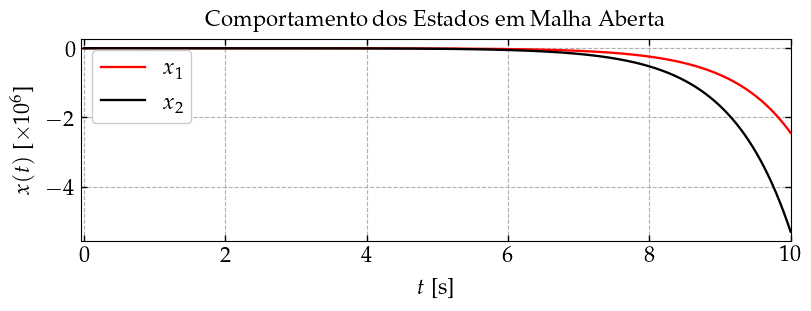

In [98]:
fig = plt.figure(figsize=(8, 3), layout='constrained')
axs = fig.subplot_mosaic([["x"]])

_ = gph.plot(
    axs['x'], time_history, plant_output,
    xlabel='$t$', x_unit='s', x_use_prefixes=True,
    ylabel=r'$x(t)$', color=['red', 'black'],
    label=[fr'$x_1$', fr'$x_2$'],
    cfg=cfg, title='Comportamento dos Estados em Malha Aberta',
    x_pad=(0.005, 0.0), y_pad=(0.05, 0.05)
)

### Projeto do Controlador e do ETM

In [215]:
def solve_problem(
    h: float,
    υ: float,
    σ: float,
    eps: float = 1e-6,
):
  n_x = plant.nx
  n_u = plant.nu

  Onx = np.zeros((n_x, n_x))

  matrices = plant.evaluate_matrices(None, None, None)
  A = matrices['A']
  B = matrices['B']

  e = nm.get_e(5 * [n_x])

  for i in range(1, len(e)):
    e[i] = cp.Parameter(e[i].shape, value=e[i], name=f"e{i}")

  constraints = []

  Ptil = cp.Variable((n_x, n_x), PSD=True)
  Mtil = cp.Variable((2 * n_x, 2 * n_x), PSD=True)
  Q1til = cp.Variable((n_x, n_x), symmetric=True)
  Q2til = cp.Variable((n_x, n_x))
  Q3til = cp.Variable((n_x, n_x))
  S1til = cp.Variable((n_x, n_x), symmetric=True)
  S2til = cp.Variable((n_x, n_x))
  S3til = cp.Variable((n_x, n_x))
  Ktil = cp.Variable((n_u, n_x))
  Ktil = cp.Parameter((n_u, n_x), value=np.array([[1.6, -2.0]]))

  Rtil = cp.Variable((n_x, n_x), PSD=True)
  Ξtil = cp.Variable((n_x, n_x), PSD=True)
  Ψtil = cp.Variable((n_x, n_x), PSD=True)

  X = cp.Variable((n_x, n_x))
  Ytil = cp.Variable((2 * n_x, e[1].shape[1]))

  Rcal = cp.bmat([[Rtil, Onx],
                  [Onx, 3. * Rtil]])

  Fscr = e[1].T + υ * e[2].T + υ * e[4].T

  κ1 = cp.bmat([[e[2]], [e[5]]])
  κ2 = cp.bmat([[e[1] - e[2]],
                [e[1] + e[2] - 2. * e[3]]])

  def get_Θ(ω):
    Bscr = A @ X @ e[1] + B @ Ktil @ X @ e[2] + + \
        B @ Ktil @ X @ e[5] - X @ e[4]
    Θ1 = (e[1] - e[2]).T @ S1til @ (e[1] - e[2]) + \
        nm.He((e[1] - e[2]).T @ (S2til @ e[2] + S3til @ e[5]))
    Θ2 = nm.He(e[3].T @ (Q2til @ e[2] + Q3til @ e[5]))
    Θ3 = nm.He(e[1].T @ (Q1til @ e[3] + Q2til @ e[2] + Q3til @ e[5]))
    Θ4 = nm.He(e[4].T @ (S1til @ (e[1] - e[2]) + S2til @
               e[2] + S3til @ e[5])) + e[4].T @ Rtil @ e[4]
    return nm.He(e[1].T @ Ptil @ e[4] + Fscr @ Bscr - κ2.T @ Ytil) - e[5].T @ Ξtil @ e[5] - \
        Θ1 - ω * Θ2 - h * e[3].T @ Q1til @ e[3] + σ * e[2].T @ Ξtil @ e[2] + \
        (h - ω) * Θ3 + (h - 2.0 * ω) * κ1.T @ Mtil @ κ1 + (h - ω) * Θ4

  def get_Λ():
    Γ1 = get_Θ(0)

    Γ2_11 = get_Θ(h)
    Γ2_12 = Ytil.T

    Γ2_21 = Γ2_12.T
    Γ2_22 = - (1. / h) * Rcal

    Γ2 = cp.bmat([[Γ2_11, Γ2_12],
                  [Γ2_21, Γ2_22]])

    return Γ1, Γ2

  Γ1, Γ2 = get_Λ()
  constraints += [Γ1 << -eps * np.eye(Γ1.shape[0])]
  constraints += [Γ2 << -eps * np.eye(Γ2.shape[0])]

  constraints += [Ψtil >> eps * np.eye(n_x)]
  constraints += [Ξtil >> eps * np.eye(n_x)]

  obj = cp.Minimize(cp.trace(Ξtil))
  prob = cp.Problem(obj, constraints)

  # Solve the problem using the MOSEK solver
  prob.solve(solver=cp.MOSEK, verbose=False, ignore_dpp=True)

  # Initialize variables to store results
  design_results = None

  # Display the results
  if prob.status not in ["infeasible", "unbounded"]:
    Xinv = np.linalg.inv(X.value)
    Ξ = Xinv.T @ Ξtil.value @ Xinv
    Ψ = np.linalg.inv(Ψtil.value)
    P = Xinv.T @ Ptil.value @ Xinv
    S2 = Xinv.T @ S2til.value @ Xinv
    K = Ktil.value
    etm_results = {'Ξ': Ξ, 'Ψ': Ψ}
    design_results = {
        'optimal_value': prob.value,
        'etm': etm_results,
        'controller': {'K': K},
        'lyapunov': [P, S2],
    }
  else:
    design_results = None

  return design_results

In [301]:
sampling_period = 1e-1
υ = 1e-1
σ = 0.3

prob_results = solve_problem(h=sampling_period, υ=υ, σ=σ)

if prob_results is not None:
  Ξ = prob_results['etm']['Ξ']
  K = prob_results['controller']['K']
  P, S2 = prob_results['lyapunov']

  Ψ = σ * Ξ
  prob_results['etm']['Ψ'] = Ψ

  display(Math(rf'\Xi = {tex.mat2tex(Ξ)}'))
  display(Math(rf'P = {tex.mat2tex(P)}'))

  display(Math(rf'K = {tex.mat2tex(K)}'))

SolverError: Solver 'MOSEK' failed. Try another solver, or solve with verbose=True for more information.

In [290]:
config["design_params"]['h'] = sampling_period
config["duration"] = 15

In [291]:
y_hist, time_history, u_hist, event_times = closed_loop_setm(
    x0, config, prob_results)

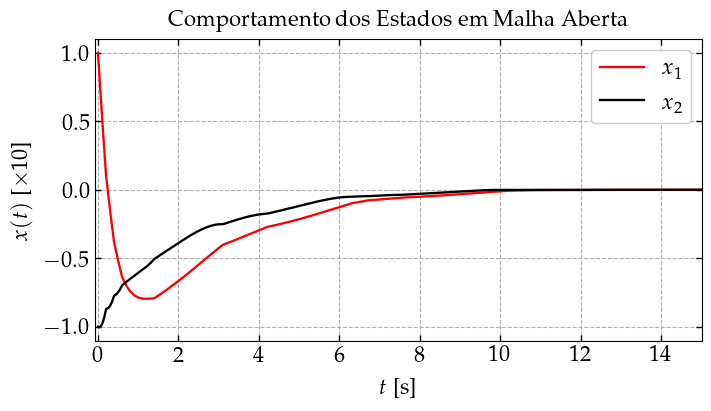

In [292]:
fig = plt.figure(figsize=(7, 4), layout='constrained')
axs = fig.subplot_mosaic([["x"]])

_ = gph.plot(
    axs['x'], time_history, y_hist,
    xlabel='$t$', x_unit='s', x_use_prefixes=True,
    ylabel=r'$x(t)$', color=['red', 'black'],
    label=[fr'$x_1$', fr'$x_2$'],
    cfg=cfg, title='Comportamento dos Estados em Malha Aberta',
    x_pad=(0.005, 0.0), y_pad=(0.05, 0.05)
)

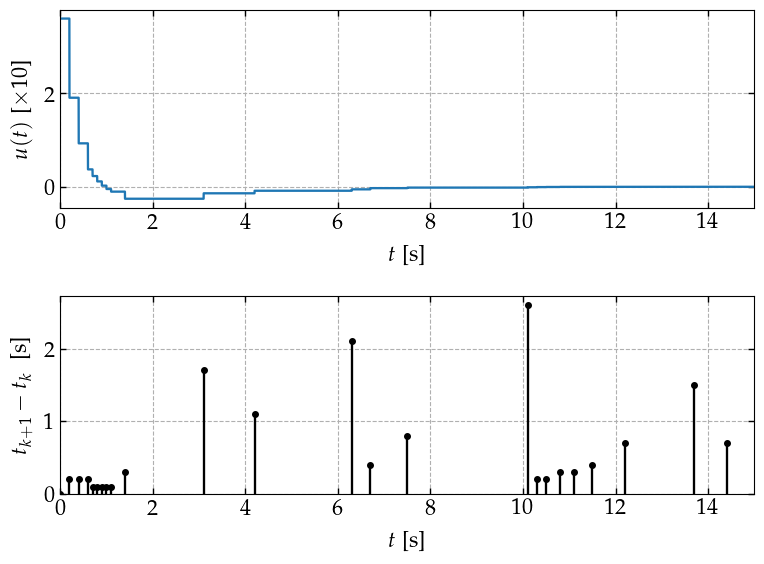

In [293]:
mosaic = [['control'], ['iet']]
fig, axs = plt.subplot_mosaic(mosaic, figsize=(8, 6))

inter_event_times = nm.compute_deltas(event_times)

for i in range(plant.nu):
  gph.plot(
      axs['control'], time_history, u_hist, xlabel='$t$', x_unit='s', x_use_prefixes=True,
      ylabel=r'$u(t)$', y_pad=(0.05, 0.05),
      cfg={**cfg, 'style': {'color': colors_list[0], "linestyle": ["-"], }},)

gph.stem(
    axs['iet'], event_times, inter_event_times,
    reuse_previous=False, y_pad=(0.0, 0.05), x_use_prefixes=True,
    xlabel='$t$', x_unit='s', x_range=(0.0, time_history[-1]),
    ylabel='$t_{k+1} - t_k\\;$', y_unit='s', y_use_prefixes=True,
    cfg={**cfg, 'limits': {'x_min': 0, 'x_max': time_history[-1]}})

plt.tight_layout(pad=2.)

In [294]:
import numpy as np
from collections import defaultdict
import networkx as nx


def projective_eps_net(eps):
  N = int(np.ceil(np.pi / eps))
  theta = np.linspace(0, np.pi, N, endpoint=False)
  X = np.vstack([np.cos(theta), np.sin(theta)]).T
  return X, theta


class RecurrenceCache:
  def __init__(self):
    self.cache = {}

  def get_k_sequence(self, x0, config, prob_results):
    key = tuple(np.round(x0, 12))
    if key in self.cache:
      return self.cache[key]

    h = config["design_params"]["h"]

    # ===== USER MODEL CALL =====
    event_times = recurrence_model(x0, config, prob_results)
    inter_event_times = nm.compute_deltas(event_times[1:])
    k_seq = tuple(int(round(t / h)) for t in inter_event_times)
    # ===========================

    self.cache[key] = k_seq
    return k_seq


def build_symbolic_graph_projective(l, eps, config, prob_results):

  cache = RecurrenceCache()

  # Deterministic projective sampling
  initial_states, theta = projective_eps_net(eps)

  # Symbolic partition
  partition = defaultdict(list)

  for x0, th in zip(initial_states, theta):
    k_seq = cache.get_k_sequence(x0, config, prob_results)
    if len(k_seq) >= l:
      word = tuple(k_seq[:l])
      partition[word].append(th)

  # Graph construction
  G = nx.DiGraph()

  for x0 in initial_states:
    k_seq = cache.get_k_sequence(x0, config, prob_results)
    if len(k_seq) > l:
      for i in range(len(k_seq) - l):
        state_curr = tuple(k_seq[i:i+l])
        state_next = tuple(k_seq[i+1:i+l+1])
        k_out = state_curr[0]

        G.add_edge(state_curr, state_next,
                   weight=k_out, label=str(k_out))

  # Attach geometric information
  for word, th_list in partition.items():
    if word not in G.nodes:
      G.add_node(word)
    G.nodes[word]["theta_points"] = np.array(th_list)

  # Geometric metrics (exact for deterministic P1 grid)
  d_min = np.pi / len(theta)
  rc = d_min
  kappa = 1.0

  # Report
  print("=== Geometric Sampling Report ===")
  print(f"Number of samples: {len(theta)}")
  print(f"Angular covering radius rc = {rc:e}")
  print(f"Min angular distance = {d_min:e}")
  print(f"Condition number kappa = {kappa}")
  print(f"Quasi-infinitesimal: {d_min < 1e-6}")

  print("=== Symbolic Graph Report ===")
  print(f"Number of ℓ-symbolic cells: {len(partition)}")
  print(f"Graph nodes: {G.number_of_nodes()}")
  print(f"Graph edges: {G.number_of_edges()}")

  return initial_states, theta, partition, G, d_min, rc, kappa


l = 2
eps = 1e-3

initial_states, theta, partition, G, d_min, rc, kappa = build_symbolic_graph_projective(
    l=l,
    eps=eps,
    config=config,
    prob_results=prob_results
)

=== Geometric Sampling Report ===
Number of samples: 3142
Angular covering radius rc = 9.998704e-04
Min angular distance = 9.998704e-04
Condition number kappa = 1.0
Quasi-infinitesimal: False
=== Symbolic Graph Report ===
Number of ℓ-symbolic cells: 86
Graph nodes: 333
Graph edges: 1925


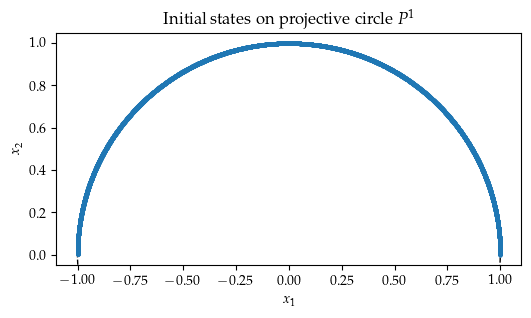

In [295]:
import matplotlib.pyplot as plt


def plot_initial_states_projective(theta, initial_states):
  fig, ax = plt.subplots(figsize=(6, 6))

  # Plot unit circle
  circle = plt.Circle((0, 0), 1.0, fill=False, linestyle='--')
  ax.add_artist(circle)

  # Plot sampled points
  ax.scatter(initial_states[:, 0], initial_states[:, 1], s=5)

  ax.set_aspect('equal')
  ax.set_xlabel(r"$x_1$")
  ax.set_ylabel(r"$x_2$")
  ax.set_title(r"Initial states on projective circle $P^1$")
  plt.show()


plot_initial_states_projective(theta, initial_states)
# plot_symbolic_partition(theta, partition)

In [296]:
import networkx as nx
from pyvis.network import Network


def visualize_sequence_in_graph(G, sequence=None, filename="symbolic_graph.html"):
  """
  G: grafo NetworkX
  sequence: lista de estados [s1, s2, s3, ...] que representa a trajetória desejada
  """
  net = Network(notebook=True, directed=True, width="100%", height="95vh")

  # Detecta atratores (SCCs)
  sccs = list(nx.strongly_connected_components(G))
  attractor_nodes = set()
  for scc in sccs:
    if len(scc) > 1:
      attractor_nodes.update(scc)
    else:
      node = next(iter(scc))
      if G.has_edge(node, node):
        attractor_nodes.add(node)

  # Mapeamento de IDs válidos
  node_id_map = {node: str(i) for i, node in enumerate(G.nodes)}

  # Adiciona nós
  for node, node_id in node_id_map.items():
    if sequence and node in sequence:
      color = "#00BFFF"  # azul claro para sequência
    elif node in attractor_nodes:
      color = "#FF8C00"  # laranja para atratores
    else:
      color = "#97c2fc"  # azul padrão

    net.add_node(
        node_id,
        label=str(node),
        title=f"Symbolic state {node}",
        shape="circle",
        size=35,
        color=color,
        font={"size": 16, "face": "Arial", "align": "center"},
    )

  # Adiciona arestas
  for u, v, data in G.edges(data=True):
    u_id = node_id_map[u]
    v_id = node_id_map[v]
    weight = data.get("weight")

    # Aresta faz parte da sequência?
    is_in_sequence = False
    if sequence:
      for i in range(len(sequence) - 1):
        if u == sequence[i] and v == sequence[i + 1]:
          is_in_sequence = True
          break

    # Define cores e largura
    if is_in_sequence:
      edge_color = "#FF00FF"  # magenta para sequência
      width = 3
    elif u in attractor_nodes and v in attractor_nodes:
      edge_color = "#FF4500"  # laranja escuro para atratores
      width = 2
    else:
      edge_color = "#888"      # cinza padrão
      width = 1

    if weight is not None:
      net.add_edge(u_id, v_id, label=str(weight), title=str(weight),
                   color=edge_color, width=width)
    else:
      net.add_edge(u_id, v_id, color=edge_color, width=width)

  # Layout interativo
  net.force_atlas_2based(
      gravity=-50, central_gravity=0.01, spring_length=100)

  # Exibe no notebook
  net.show(filename)


_seq = tuple(int(round(t / config['design_params']['h']))
             for t in inter_event_times)
sequence_pairs = [(_seq[i], _seq[i+1])
                  for i in range(len(_seq)-1)]

visualize_sequence_in_graph(G, sequence_pairs)

symbolic_graph.html


In [297]:
# import networkx as nx
# import numpy as np


# def analyze_symbolic_graph(G, l=2, weight_attr='weight'):
#   """
#   Análise completa de um grafo simbólico l-completo.

#   Parâmetros:
#   G : networkx.DiGraph
#       Grafo simbólico.
#   l : int
#       Comprimento de caminhos para análise de padrões.
#   weight_attr : str
#       Nome do atributo de peso das arestas (se existir).
#   """

#   print("=== MATRIZ DE ADJACÊNCIA ===")
#   A = nx.adjacency_matrix(G, weight=weight_attr).todense()
#   print(A)

#   print("\n=== GRAU DOS NÓS ===")
#   in_deg = dict(G.in_degree(weight=weight_attr))
#   out_deg = dict(G.out_degree(weight=weight_attr))
#   print("Grau de entrada:", in_deg)
#   print("Grau de saída:", out_deg)

#   print("\n=== COMPONENTES FORTEMENTE CONECTADAS (SCCs) ===")
#   sccs = list(nx.strongly_connected_components(G))
#   for i, scc in enumerate(sccs):
#     print(f"SCC {i+1}: {scc}")

#   print("\n=== CICLOS SIMPLES ===")
#   cycles = list(nx.simple_cycles(G))
#   print(f"Número de ciclos: {len(cycles)}")
#   if len(cycles) > 0:
#     print("Exemplo de ciclos:", cycles[:5])  # mostra até 5 ciclos

#   print(f"\n=== CAMINHOS DE COMPRIMENTO {l} ===")
#   # matriz de caminhos de comprimento l
#   paths_length_l = np.linalg.matrix_power(A, l)
#   print(paths_length_l)
#   print(
#       "Nota: A[i,j] representa número de caminhos de comprimento", l, "de i para j.")

#   return {
#       'adjacency_matrix': A,
#       'in_degree': in_deg,
#       'out_degree': out_deg,
#       'sccs': sccs,
#       'cycles': cycles,
#       'paths_length_l': paths_length_l
#   }


# # Exemplo de uso
# results = analyze_symbolic_graph(G, l=2)

In [298]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.patches import Patch


def plot_adjacency_matrix_full_v2(G, sequence=None, figsize=(14, 12), dpi=150):
  """
  Plota a matriz de adjacência do grafo G, destacando:
  - Atratores (SCCs)
  - Sequências específicas
  - Auto-loops
  - Todos os estados do grafo
  - Legenda explicativa
  """

  print("Gerando Matriz de Adjacência Completa...")

  # --- 1. Determina SCCs para atratores ---
  sccs = list(nx.strongly_connected_components(G))
  attractor_nodes = set()
  for scc in sccs:
    if len(scc) > 1:
      attractor_nodes.update(scc)
    else:
      node = next(iter(scc))
      if G.has_edge(node, node):
        attractor_nodes.add(node)

  # --- 2. Lista de todos os nós (ordenados) ---
  nodes = sorted(list(G.nodes()))
  n = len(nodes)
  node_to_idx = {node: i for i, node in enumerate(nodes)}

  # --- 3. Cria matriz de pesos ---
  matrix = np.full((n, n), np.nan)
  auto_loops = set()
  for u, v, data in G.edges(data=True):
    i = node_to_idx[u]
    j = node_to_idx[v]
    w = data.get('weight', 1)
    matrix[i, j] = w
    if u == v:
      auto_loops.add(u)

  # --- 4. Criação da figura ---
  fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

  cmap = plt.cm.viridis.copy()
  cmap.set_bad(color='white')  # células sem conexão ficam brancas

  # Plota a matriz de pesos
  cax = ax.imshow(matrix, cmap=cmap, interpolation='none', origin='upper')

  # Barra de cores
  cbar = fig.colorbar(cax, fraction=0.046, pad=0.04)
  cbar.set_label(r'Peso da Aresta (weight)',
                 rotation=270, labelpad=20, fontsize=12)

  # --- 5. Destaca atratores ---
  for node in attractor_nodes:
    i = node_to_idx[node]
    rect = plt.Rectangle((i - 0.5, i - 0.5), 1, 1,
                         edgecolor='orange', facecolor='none', lw=2, label='_nolegend_')
    ax.add_patch(rect)

  # --- 6. Destaca sequência específica ---
  if sequence is not None and len(sequence) >= 2:
    if isinstance(sequence[0], int):
      sequence_pairs = [(sequence[i], sequence[i+1])
                        for i in range(len(sequence)-1)]
    else:
      sequence_pairs = sequence

    for u, v in sequence_pairs:
      if u in node_to_idx and v in node_to_idx:
        i = node_to_idx[u]
        j = node_to_idx[v]
        rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1,
                             edgecolor='magenta', facecolor='none', lw=2, label='_nolegend_')
        ax.add_patch(rect)

  # --- 7. Destaca auto-loops ---
  for node in auto_loops:
    i = node_to_idx[node]
    rect = plt.Rectangle((i - 0.5, i - 0.5), 1, 1,
                         edgecolor='red', facecolor='none', lw=2, linestyle='--', label='_nolegend_')
    ax.add_patch(rect)

  # --- 8. Eixos e rótulos ---
  ax.set_title(
      f"Matriz de Adjacência Completa do Grafo ({n} estados)", fontsize=14, fontweight='bold')
  ax.set_xlabel("Estado Destino", fontsize=12)
  ax.set_ylabel("Estado Origem", fontsize=12)
  ax.grid(which='major', color='gray',
          linestyle=':', linewidth=0.5, alpha=0.3)

  # Ajusta rótulos para grafos grandes
  if n < 40:
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels([str(x) for x in nodes], rotation=90, fontsize=8)
    ax.set_yticklabels([str(x) for x in nodes], fontsize=8)
  else:
    step = max(1, n // 10)
    ax.set_xticks(np.arange(0, n, step))
    ax.set_yticks(np.arange(0, n, step))

  # --- 9. Legenda ---
  legend_elements = [
      Patch(edgecolor='orange', facecolor='none',
            lw=2, label='Atrator (SCC)'),
      Patch(edgecolor='magenta', facecolor='none',
            lw=2, label='Sequência Específica'),
      Patch(edgecolor='red', facecolor='none',
            lw=2, linestyle='--', label='Auto-loop')
  ]
  ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

  plt.tight_layout()
  plt.show()


# plot_adjacency_matrix_full_v2(G, sequence_pairs)

In [299]:
import numpy as np
import networkx as nx


def calcular_entropia_comportamental(G):
  print(f"Analisando grafo com {G.number_of_nodes()} estados...")

  # 1. Obter a Matriz de Adjacência (Não-ponderada)
  # A entropia conta "número de caminhos", então usamos 0 ou 1.
  # Se houver múltiplas arestas com rótulos diferentes entre dois nós,
  # usar MultiDiGraph seria necessário, mas para DiGraph padrão:
  A = nx.adjacency_matrix(G).todense()

  # 2. Calcular Autovalores (Eigenvalues)
  # A função eigvals retorna todos os autovalores (podem ser complexos)
  eigenvalues = np.linalg.eigvals(A)

  # 3. Pegar o Raio Espectral (O maior valor absoluto)
  # Pelo Teorema de Perron-Frobenius, para matrizes não-negativas,
  # existe um autovalor real positivo dominante.
  lambda_max = max(abs(eigenvalues))

  print(f"Maior Autovalor (Raio Espectral): {lambda_max:.4f}")

  # 4. Calcular Entropia
  # Se lambda_max < 1, o sistema colapsa (entropia 0 ou negativa matematicamente, mas física = 0)
  # Se lambda_max = 1, entropia = 0 (Estável/Periódico)
  # Se lambda_max > 1, entropia > 0 (Caótico/Expansivo)

  if lambda_max <= 1.0 + 1e-9:  # Tolerância para erro numérico
    entropy = 0.0
  else:
    # Base 2 (bits) ou Base e (nats). Geralmente em dinâmica usa-se log natural.
    entropy = np.log(lambda_max)

  return entropy, lambda_max


# --- Execução ---
# Supondo que seu grafo G já esteja carregado
h, lam = calcular_entropia_comportamental(G)

print("-" * 30)
print(f"Entropia Comportamental h(S): {h:.5f}")
print("-" * 30)

if h < 1e-5:
  print("CONCLUSÃO: O sistema NÃO É caótico (h ≈ 0).")
  print("O comportamento é previsível, estável ou periódico.")
else:
  print(f"CONCLUSÃO: O sistema É caótico ou expansivo.")
  print(f"A incerteza cresce a uma taxa de {np.exp(h):.2f}x a cada passo.")

Analisando grafo com 333 estados...
Maior Autovalor (Raio Espectral): 91.1818
------------------------------
Entropia Comportamental h(S): 4.51286
------------------------------
CONCLUSÃO: O sistema É caótico ou expansivo.
A incerteza cresce a uma taxa de 91.18x a cada passo.


In [300]:
# # Isola apenas o maior Atrator (SCC)
# largest_scc_nodes = max(nx.strongly_connected_components(G), key=len)
# subgraph = G.subgraph(largest_scc_nodes)

# # Calcula entropia apenas dele
# h_scc, lam_scc = calcular_entropia_comportamental(subgraph)

# print(f"Entropia do Atrator Principal: {h_scc:.5f}")
# print(f"Taxa de expansão interna: {lam_scc:.4f}")